<div align="center">
    <div><img src="../assets/redis_logo.svg" style="width: 130px"> </div>
    <div style="display: inline-block; text-align: center; margin-bottom: 10px;">
        <span style="font-size: 36px;"><b>Multi-document RAG based on LangGraph with Redis Retrieval Agent using Ollama and React agents</b></span>
        <br />
    </div>
    <br />
</div>

# 
[Retrieval Agents](https://python.langchain.com/docs/use_cases/question_answering/conversational_retrieval_agents) are useful when we want to make decisions about whether to retrieve from an index. Here we construct the same single index of 10Ks and earning calls along with some metadata we got from SEC that we tried in notebook 04 with ideas borrowed from notebook 05. The purpose of this notebook to demonstrate an agentic approach to RAG where a React agent powered by an LLM (a local llama3 LLM here) can react to the results of different tools in its disposal and/or employ different tools to find an answer to user's question. One the tools that the agent is using is a Redis retriever. This Redis retriever tool can run vector similarity search for a given question, and optionally apply filters to harness the full benefits of Redis Hybrid search that we showcased in notebook 04. The other objective of this notebook is to showcase an orchestrated effort (We use [LangGraph](https://python.langchain.com/docs/langgraph) for this purpose) to infer the relevancy of users' question to our domain (finance here) and detection of pre-specified topics of the question; here we want to determine whether a question is more related to an earning call document or a 10K filing or it is out of our domain. We use the same the LLM here with different prompting and chain strategy, but you are not limited to one LLM. You can plug in your own fine-tuned or task-specific LLM here or even use other NLP/ML models that you trust (or certified) and explain for your purpose. 




![React Graph](react_graph.png)

## Environment Setup

In [43]:
import os
import warnings
import dotenv
# mute warnings
warnings.filterwarnings('ignore')
# load env vars from .env file
dotenv.load_dotenv()
dir_path = os.getcwd()
parent_directory = os.path.dirname(dir_path)
os.environ["ROOT_DIR"] = parent_directory
REDIS_URL = os.getenv("REDIS_URL")
print(dir_path)
print(parent_directory)

/Users/rouzbeh.farahmand/PycharmProjects/boa-financial-rag-workshop/2_RAG_patterns_with_redis
/Users/rouzbeh.farahmand/PycharmProjects/boa-financial-rag-workshop


### Install Python Dependencies

In [44]:
%pip install -r $ROOT_DIR/requirements.txt

Note: you may need to restart the kernel to use updated packages.


### SentenceTransformerEmbeddings Models Cache folder
We are using `SentenceTransformerEmbeddings` in this demo and here we specify the cache folder. If you already downloaded the models in a local file system, set this folder here, otherwise the library tries to download the models in this folder if not available locally.

In particular, this models will be downloaded if not present in the cache folder:

models/models--sentence-transformers--all-MiniLM-L6-v2

In [45]:
#setting the local downloaded sentence transformer models folder
os.environ["TRANSFORMERS_CACHE"] = f"{parent_directory}/models"

In [46]:
from langchain.embeddings.sentence_transformer import SentenceTransformerEmbeddings

embeddings = SentenceTransformerEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2",
                                           cache_folder=os.getenv("TRANSFORMERS_CACHE", f"{parent_directory}/models"))

### Build your Redis index 
Skip this section if you have already built your index in previous notebook.


In [47]:
from redisvl.index import SearchIndex
from redisvl.schema import IndexSchema
from redis import Redis
index_name = 'langchain'
prefix = 'chunk'
schema = IndexSchema.from_yaml('sec_index.yaml')
client = Redis.from_url(REDIS_URL)
# create an index from schema and the client
index = SearchIndex(schema, client)
index.create(overwrite=True, drop=True)

12:39:34 redisvl.index.index INFO   Index already exists, overwriting.


In [48]:
# Skip if you have already done populated your index.
from ingestion import get_sec_data
from ingestion import redis_bulk_upload

sec_data = get_sec_data()

 ✅ Loaded doc info for  110 tickers...


In [49]:
redis_bulk_upload(sec_data, index, embeddings, tickers=['AAPL','AMZN'])

✅ Loaded 108 10K chunks for ticker=AAPL from AAPL-2021-10K.pdf
✅ Loaded 94 10K chunks for ticker=AAPL from AAPL-2023-10K.pdf
✅ Loaded 103 10K chunks for ticker=AAPL from AAPL-2022-10K.pdf
✅ Loaded 27 earning_call chunks for ticker=AAPL from 2018-May-01-AAPL.txt
✅ Loaded 31 earning_call chunks for ticker=AAPL from 2019-Oct-30-AAPL.txt
✅ Loaded 30 earning_call chunks for ticker=AAPL from 2016-Jan-26-AAPL.txt
✅ Loaded 31 earning_call chunks for ticker=AAPL from 2020-Jul-30-AAPL.txt
✅ Loaded 30 earning_call chunks for ticker=AAPL from 2017-Aug-01-AAPL.txt
✅ Loaded 29 earning_call chunks for ticker=AAPL from 2020-Jan-28-AAPL.txt
✅ Loaded 34 earning_call chunks for ticker=AAPL from 2016-Apr-26-AAPL.txt
✅ Loaded 29 earning_call chunks for ticker=AAPL from 2017-Jan-31-AAPL.txt
✅ Loaded 28 earning_call chunks for ticker=AAPL from 2019-Apr-30-AAPL.txt
✅ Loaded 26 earning_call chunks for ticker=AAPL from 2017-Nov-02-AAPL.txt
✅ Loaded 31 earning_call chunks for ticker=AAPL from 2016-Oct-25-AAPL.tx

## Redis as a Langchain Retriever


In [50]:
from langchain_community.vectorstores import Redis as LangChainRedis
from utils import create_langchain_schemas_from_redis_schema

index_name = 'langchain'

vec_schema , main_schema = create_langchain_schemas_from_redis_schema('sec_index.yaml')

rds = LangChainRedis.from_existing_index( embedding = embeddings, 
                                          index_name = index_name, 
                                          schema = main_schema)
redis_retriever = rds.as_retriever()


Test if the Redis index is working and returning relevant document.

In [51]:
rds.similarity_search(query="Apple in 2022", k=4, distance_threshold=0.8)

[Document(page_content='The Company’s global operations are subject to complex and changing laws and regulations on subjects, including antitrust; privacy, data security and data localization; consumer protection; advertising, sales, billing and e-commerce; financial services and technology; product liability; intellectual property ownership and infringement; digital platforms; internet, telecommunications, and mobile communications; media, television, film and digital content; availability of third-party software applications and services; labor and employment; anticorruption; import, export and trade; foreign exchange controls and cash repatriation restrictions; anti–money laundering; foreign ownership and investment; tax; and environmental, health and safety, including electronic waste, recycling, and climate change.\n\nApple Inc. | 2022 Form 10-K | 13', metadata={'id': 'chunk:AAPL-2022-10K.pdf-ef8249da-8660-49d4-a5bd-7700c2b7049e', 'chunk_id': 'AAPL-2022-10K.pdf-ef8249da-8660-49d4-

Now we create a Redis retriever tool.

In [52]:
from langchain_core.prompts import PromptTemplate
from langgraph.graph.message import add_messages
import operator
from typing import Annotated, TypedDict, Union, Sequence, List
from langchain.agents import create_react_agent
from langchain_community.chat_models import ChatOllama
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
from langchain_core.tools import tool
from langgraph.prebuilt import ToolExecutor, ToolInvocation

@tool
def get_relevant_docs_from_redis(input: str, filters = None):
    """
    Get the relevant docs from a redis query.
    """
    
    if filters is None:
        redis_response = rds.similarity_search(query=input, k=4, distance_threshold=0.8)
    else:
        redis_response = rds.similarity_search(query=input, k=4, distance_threshold=0.8, filter=filters)
    
    return redis_response


@tool
def response_to_irrelevant_questions(input: str):
    """
    In case of getting questions that are not relevant to finance prepare a response.
    """
    
    default_response = [f"Your question does not seem to be relevant to finance. Please only ask questions that are relevant to financials of companies that are usually reported in 10K or earning calls."]
    
    return default_response


tools = [get_relevant_docs_from_redis, response_to_irrelevant_questions]
tool_executor = ToolExecutor(tools)
tool_names = list(tool_executor.tool_map.keys())

class AgentState(TypedDict):
    input: str
    chat_history: list[BaseMessage]
    agent_outcome: Union[AgentAction, AgentFinish, None]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]
    messages: Annotated[Sequence[BaseMessage], add_messages]
    filters : str
    question_relevancy: str
    generation: str
    documents: List[str]


agent_model = ChatOllama(model="llama3", temperature=0)
agent_local_prompt = PromptTemplate(
        template="""
            You are an assistant for question-answering tasks about financial documents. Use the tools provided to you to answer them:

            {tools}
            Question: the input question you must answer.
            Thought: you should always think about what to do. 
            Action: the action to take, should be one of [{tool_names}] or the end of conversation with a response you get from using a tool called `response_to_irrelevant_questions`. 
            Action Input: the input to the action
            Observation: the result of the action is a snippet of financial information related to a company
            ... (this Thought/Action/Action Input/Observation can repeat 2 times). After 2 times try your best to answer the question.
            Action Input: Other agents will resolve the answer to the question so don't try to answer the question yourself. Just run the tools and retrieve the related documents. 
            
            Question: {input}
            Thought:{agent_scratchpad}
            """,
        input_variables=["tools","tool_names", "input","agent_scratchpad"],
    )


agent_runnable = create_react_agent(agent_model, tools, agent_local_prompt)


In [53]:
tool_names

['get_relevant_docs_from_redis', 'response_to_irrelevant_questions']

In [54]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate,PromptTemplate
from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama

# Prompt
#prompt = hub.pull("rlm/rag-prompt")
def get_gen_rag_chain():
    # LLM
    gen_llm = ChatOllama(model="llama3", temperature=0)
    gen_local_prompt = PromptTemplate(input_variables=['context', 'question'], template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:")

    # Chain
    gen_rag_chain = gen_local_prompt | gen_llm | StrOutputParser()
    return gen_rag_chain

q="what is the deferred apple revenue in 2022?"
context = """As of September 24, 2022 and September 25, 2021, 
            the Company had total deferred revenue of $12.4 
            billion and $11.9 billion, respectively. As of 
            September 24, 2022, the Company expects 64% of 
            total deferred revenue to be realized in less """

my_gen_rag_chain = get_gen_rag_chain()
    # Run Gen LLM
response = my_gen_rag_chain.invoke({"context": context, "question": q})
print(response)

Based on the provided context, I don't know the specific deferred apple revenue for 2022. However, I can tell you that as of September 24, 2022, Apple had total deferred revenue of $12.4 billion.


In [55]:
def get_question_classifier():
    question_classifier_llm = ChatOllama(model="llama3", format="json", temperature=0)
    question_classifier_prompt = PromptTemplate(
        template="""Your task is to analyze and classify a question and formulate a new question related to the topic that you found. You have to determine if the answer for the question can be found in "earning_calls" or "10K" financial filings. So choose either "earning_calls" or "10K" as the assigned class. If you are unsure assign `None`. Assign three classes of 'earning_call' or '10K' or 'None' as a JSON with a single key 'question_class'. Also add a new key called 'new_question' and try to rewrite the given question based on the class you detected. If the detected class is 'None' or your could find a relevance of the questions to those 'earning_calls' or '10K' return 'None' as the new question. 
        
        Also add a new field in the JSON called 'question_type'. You have to determine if the answer to user's question is likely to be a number or an explanation. if the answer to the question is likely to be number assign 'numeric' and if the answer is likely to be explanation assign `explain` to the 'question_type'.   
        
        Only return a valid JSON objects as your response. If you have new information or notes, add a new field in the JSON called `note` and add your explanation in that `note` field.: \n\n {question}.  \n """,
        input_variables=["question"],
    )
    question_classifier = question_classifier_prompt | question_classifier_llm | JsonOutputParser()
    return question_classifier

my_question_classifier = get_question_classifier()
my_question_classifier.invoke({"question": "what is the aapl revenue in 2022?"})

{'question_class': '10K',
 'new_question': "What are Apple's reported revenues for the year 2022?",
 'question_type': 'numeric'}

In [56]:
my_question_classifier.invoke({"question": "what was the mood of Tim Cook in the earning calls of 2022?"})

{'question_class': 'earning_calls',
 'new_question': "What were the key takeaways from Tim Cook's tone during Apple's earnings calls in 2022?",
 'question_type': 'explain'}

In [57]:
my_question_classifier.invoke({"question": "Why colorless green ideas are sleeping furiously?"})

{'question_class': 'None', 'new_question': 'None', 'question_type': 'explain'}

In [58]:
### Retrieval Grader
from langchain_core.output_parsers import JsonOutputParser

def get_retrieval_grader():
    retrieval_grader_llm = ChatOllama(model='llama3', format="json", temperature=0)

    retrieval_grader_prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {document} \n\n
        Here is the user question: {input} \n
        If the document contains keywords related to the user question, grade it as relevant. \n
        It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
        Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.""",
        input_variables=["input", "document"],
    )
    
    retrieval_grader = retrieval_grader_prompt | retrieval_grader_llm | JsonOutputParser()
    return retrieval_grader

my_retrieval_grader = get_retrieval_grader()

question = "apple revenue in 2022"
docs = redis_retriever.get_relevant_documents(question)
doc_txt = docs[0].page_content
print(my_retrieval_grader.invoke({"input": question, "document": doc_txt}))

score_threshold is deprecated. Use distance_threshold instead.score_threshold should only be used in similarity_search_with_relevance_scores.score_threshold will be removed in a future release.


{'score': 'yes'}


In [59]:
my_retrieval_grader.invoke({"input": "apple revenue in 2022", "document": """
We serve consumers through our online and physical stores and focus on selection, price, and convenience. We design our
stores to enable hundreds of millions of unique products to be sold by us and by third parties across dozens of product categories.
Customers access our offerings through our websites, mobile apps, Alexa, devices, streaming, and physically visiting our stores. We
also manufacture and sell electronic devices, including Kindle, Fire tablet, Fire TV , Echo, Ring, and other devices, and we develop
and produce media content. We seek to offer our customers low prices, fast and free delivery, easy-to-use functionality, and timely
customer service. In addition, we offer Amazon Prime, a membership program that includes unlimited free shipping on over 100
million items, access to unlimited streaming of tens of thousands of movies and TV episodes, including Amazon Original content,
and other benefits.
"""})

{'score': 'no'}

In [60]:
my_retrieval_grader.invoke({"input": "Amazon's revenue in 2022", "document": """
We serve consumers through our online and physical stores and focus on selection, price, and convenience. We design our
stores to enable hundreds of millions of unique products to be sold by us and by third parties across dozens of product categories.
Customers access our offerings through our websites, mobile apps, Alexa, devices, streaming, and physically visiting our stores. We
also manufacture and sell electronic devices, including Kindle, Fire tablet, Fire TV , Echo, Ring, and other devices, and we develop
and produce media content. We seek to offer our customers low prices, fast and free delivery, easy-to-use functionality, and timely
customer service. In addition, we offer Amazon Prime, a membership program that includes unlimited free shipping on over 100
million items, access to unlimited streaming of tens of thousands of movies and TV episodes, including Amazon Original content,
and other benefits.
"""})

{'score': 'yes'}

In [61]:
def custom_redis_query_translator(q):
    filters = get_redis_filters(q)
    return filters

custom_redis_query_translator("what was the performance of amzn in 2021 in nasdaq?")

'@ticker:{AMZN} | @exchange:{NASDAQ}'

In [62]:
custom_redis_query_translator("what was the performance of Apple Inc in 2021?")

'@company_name:{APPLE INC}'

### Build your RAG logic inside a Graph
Now that we have all the components for our RAG logic we will connect them through a graph.

In [63]:
from langchain_core.documents import Document
from typing import Literal
from custom_ners import get_redis_filters
from utils import *

### Edges
def check_relevancy(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the asked question is relevant to our domain and if retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    
    input = state["input"]
    documents = state["documents"]
    question_relevancy = state["question_relevancy"]
    
    if question_relevancy == 'not_relevant':
        return "generate"
    
    # Score each doc
    filtered_docs = []
    for d in documents:
        score = my_retrieval_grader.invoke({"input": input, "document": d})
        grade = score["score"]
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    
    if len(documents) - len(filtered_docs) > 2 :
        state["documents"] =  filtered_docs # ?
        return "generate"
    else:
        return "rewrite"

### Nodes

def execute_tools(state):
    

    print("RFD-DEBUG: ======== Called `execute_tools`========")
    
    if state.get("agent_outcome"):
        messages = [state["agent_outcome"]]
        last_message = messages[-1]
        if last_message.tool is not None:
            tool_name = last_message.tool
            
            tool_input = last_message.tool_input
            print(f"Calling tool: {tool_name}")
        
            #That means we have an irrelevant question
            if 'response_to_irrelevant_questions' in tool_name:
                action = ToolInvocation(
                tool='response_to_irrelevant_questions',
                tool_input=state['input'],
                )
                base_response = tool_executor.invoke(action)
                cleaned_response = str(base_response[0]) 
                return {
                    "intermediate_steps": [(state["agent_outcome"], cleaned_response)],
                    "messages": [cleaned_response],
                    "documents" : [],
                    "question_relevancy" :'not_relevant'
                }
            else:
                action = ToolInvocation(
                    tool='get_relevant_docs_from_redis',
                    tool_input={"input": state["input"], "filters":state["filters"]}
                    )
                documents = tool_executor.invoke(action)
                cleaned_response = format_docs(documents)
                return {
                    "intermediate_steps": [(state["agent_outcome"], cleaned_response)],
                    "documents" : format_docs(documents),
                    "question_relevancy" :'relevant'
                    
                }
        else:
            cleaned_response = str(last_message.log)
            return {
                "intermediate_steps": [(state["agent_outcome"], cleaned_response)],
                "documents" : []
            }
    else:
        return {
                "messages" : [state],
                "documents" : []
            }
        
def agent(state):
    try:
        agent_outcome = agent_runnable.invoke(state)
    except Exception as e:
        print(f"RFD-DEBUG AGENT ERROR: {str(e)}")
        return {"messages": [str(e)]}
    
    return {"agent_outcome": agent_outcome}

def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("--- QUERY rewrite ---")
    def combine_filters(inferred_filters, doc_type_filter="10K", filter_strategy="AND"):
        if inferred_filters is None:
            return "@doc_type:{"+f"{doc_type_filter}"+"}"
        else:
            return "@doc_type:{"+f"{doc_type_filter}"+"} " + filter_strategy +f" ({inferred_filters})"
            
        
    question = state["input"]
    documents = state["documents"]
    q_filters = custom_redis_query_translator(question)
    question_analysis = my_question_classifier.invoke({"question": question})
    print(f"---QUERY rewrite---question_analysis={question_analysis}")
    question_class = question_analysis["question_class"]
    
    if question_class != "None":
        print(f"---Question Class: Question is Related to {question_class}---")
        applied_filters = combine_filters(q_filters, doc_type_filter=question_class)
    else:
        applied_filters = combine_filters(q_filters)
        
    new_question = question_analysis["new_question"]   
    if new_question != "None":
        print(f"---Question Analysis: new_question is {new_question}---")
        rewrite_question = new_question
    else:
        rewrite_question = question
        
    print(f"---QUERY rewrite for QUESTION={question} with filters={applied_filters}---")
    
    return {"documents": documents, "input": rewrite_question, "filters": applied_filters}
    
def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    
    print("---GENERATE---")
    final_docs = state["documents"]
    final_question = state["input"]
    question_relevancy = state["question_relevancy"]
    messages = state["messages"]
    
    token_limit = 1000
    top_docs_limit = 2
    
    final_context = ""
    if question_relevancy == "not_relevant" and len(messages) > 0:
        final_context = messages
    if final_docs is not None and len(final_docs) > 0:
        final_context = str("\n".join(final_docs[:top_docs_limit]))[:token_limit]
        print(f"RFD-DEBUG:GENERATE RESPONSE based on Docs ==========")
    
    print(f"RFD-DEBUG:GENERATE === question={final_question}")
    print(f"RFD-DEBUG:GENERATE === context={final_context}")
    
    # Run Gen LLM
    generated_answer = my_gen_rag_chain.invoke({"context": final_context, "question": final_question})
    
    print(f"RFD-DEBUG:GENERATE=== generation={generated_answer}")
    return {"messages": [generated_answer], "generation": generated_answer}

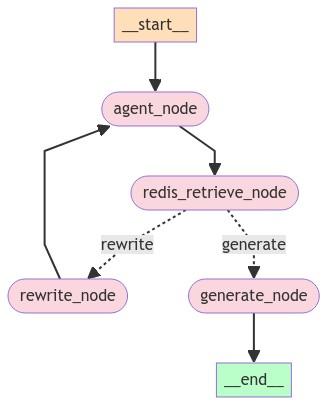

In [64]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(AgentState)

workflow.add_node("agent_node", agent)  # agent
workflow.add_node("redis_retrieve_node", execute_tools)
workflow.add_edge("agent_node", 'redis_retrieve_node')
workflow.add_node("rewrite_node", rewrite)
workflow.add_edge("rewrite_node", "agent_node")
# Decide whether to retrieve
workflow.add_conditional_edges(
    "redis_retrieve_node",
    check_relevancy,
    {
        # Translate the condition outputs to nodes in our graph
        "rewrite": "rewrite_node",
        "generate": "generate_node",
    },
)

workflow.add_node("generate_node", generate)
workflow.add_edge("generate_node", END)

workflow.set_entry_point("agent_node")

# Compile
graphapp = workflow.compile()

from IPython.display import Image, display
try:
    display(Image(graphapp.get_graph(xray=True).draw_mermaid_png()))
except:
    pass


In [65]:
import pprint

inputs = {
    "input":"What was the deferred revenue of aapl in 2022?",
}
for output in graphapp.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

"Output from node 'agent_node':"
'---'
{ 'agent_outcome': AgentAction(tool='get_relevant_docs_from_redis', tool_input='aapl" and "2022', log='I\'m ready to assist with financial document-related questions!\n\nSince this is a specific question about Apple\'s (AAPL) financials, I\'ll use my tools to try and find relevant documents.\n\nAction: get_relevant_docs_from_redis\nAction Input: "aapl" and "2022')}
'\n---\n'
RFD-DEBUG: ======== Called `execute_tools`========
Calling tool: get_relevant_docs_from_redis
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
"Output from node 'redis_retrieve_node':"
'---'
{ 'documents': [ 'The Company’s proportion of net sales by disaggregated '
                 'revenue source was generally consistent for each reportable '
                 'segment in Note 11, “Segment Information and Geographic '
                 'Data” for 2022, 2021 and 2020, except in Greater China, '
  

In [66]:
import pprint

inputs2 = {
    "input":"Why colorless green ideas are furiously sleeping?",
    "messages": [
        ("user", "Why colorless green ideas are furiously sleeping?"),
    ]
}

for output2 in graphapp.stream(inputs2):
    for key2, value2 in output2.items():
        pprint.pprint(f"Output from node '{key2}':")
        pprint.pprint("---")
        pprint.pprint(value2, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

"Output from node 'agent_node':"
'---'
{ 'agent_outcome': AgentAction(tool='response_to_irrelevant_questions', tool_input='None', log="I'm an assistant for financial document-related tasks, but I sense that this question is not relevant to finance.\n\nAction: response_to_irrelevant_questions\nAction Input: None")}
'\n---\n'
RFD-DEBUG: ======== Called `execute_tools`========
Calling tool: response_to_irrelevant_questions
"Output from node 'redis_retrieve_node':"
'---'
{ 'documents': [],
  'intermediate_steps': [ ( AgentAction(tool='response_to_irrelevant_questions', tool_input='None', log="I'm an assistant for financial document-related tasks, but I sense that this question is not relevant to finance.\n\nAction: response_to_irrelevant_questions\nAction Input: None"),
                            'Your question does not seem to be relevant to '
                            'finance. Please only ask questions that are '
                            'relevant to financials of companies that a